# start

- taking only labled data for training:
- try training with Adam,AdamW [12 epochs]
- params: resnet50,90/10,e12,bs8,SGD,conf:0.25
- img_size = 480p[852x480] previously it was 720p[1280x720]

In [1]:
# %cd test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensorV2
from torchvision import utils

from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = DEVICE
BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

num_epochs = 12
width = 852
height = 480

In [2]:
# tr = {
#     "score":[0.1,0.3,0.5],
#     "abd": ["a","b","c"],
#     "jj": [1,2,3]
# }


# [[tr[j][tr["score"].index(i)] for i in tr["score"] if i>=0.2] for j in list(tr.keys())]
# # tr["abd"][0]
# # list(tr.keys())

In [3]:
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
# train_df['annotations'].iloc[3]
train_df['annotations'] = train_df['annotations'].apply(eval)
func = lambda x: "video_"+x.split("-")[0]+"/"+x.split("-")[1]+".jpg"
# vid_func = lambda x: "video_"+x.split("-")[0]

train_df["img_path"] = train_df["image_id"].apply(func)
# train_df["vid_path"] = train_df["image_id"].apply(vid_func)
# train_df.head()
train_df["no_of_bbox"] = train_df["annotations"].apply(lambda x: len(x))
train_df = train_df[train_df["no_of_bbox"]>0].reset_index(drop=True)
train_df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,no_of_bbox
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",video_0/16.jpg,1
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",video_0/17.jpg,1
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",video_0/18.jpg,1
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",video_0/19.jpg,1
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",video_0/20.jpg,1


In [4]:
boxes = pd.DataFrame(train_df['annotations'].iloc[19], columns=['x', 'y', 'width', 'height']).astype(float).values
boxes

array([[520., 151.,  78.,  62.],
       [598., 204.,  58.,  32.]])

In [5]:
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
# boxes
# --> array([[520., 151., 598., 213.],
#        [598., 204., 656., 236.]])

# dataloader

In [6]:
class ReefDataset:
    
    def __init__(self, df, w, h, transforms=None):
        self.df = df
        self.transforms = transforms
        self.w = w
        self.h = h
        self.Wratio = h/720
        self.Hratio = w/1280
        self.ratioLst = [self.Hratio, self.Wratio, self.Hratio, self.Wratio]

        

    def can_augment(self, boxes):
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        
#         image = cv2.imread(f'{BASE_DIR}/{row["img_path"]}', cv2.IMREAD_COLOR)
# #         print(f'{BASE_DIR}/{row["img_path"]}')
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image /=255.0
        
        
#         boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values
        
#         # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
# #         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
# #         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
#         boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
#         boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720)
        
        
        
        image = cv2.imread(f'{BASE_DIR}/{row["img_path"]}', cv2.IMREAD_COLOR)
        image = cv2.resize(image,(852,480),cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        image /=255.0
        
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values

        # bbox resizer
        bbox = []
        for box in boxes:
            box = [float(int(a * b)) for a, b in zip(box, self.ratioLst)] 
            bbox.append(box)
        boxes = np.array(bbox)
        
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,self.w)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,self.h)
        
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

In [7]:
df_train = train_df.iloc[0: 4427]
df_val = train_df.iloc[4428:4918]

ds_train = ReefDataset(df_train,width,height)
ds_val = ReefDataset(df_val,width,height)

(480, 852, 3)


'\nboxes:  [[344. 105.  66.  73.]]\n[66.]\n'

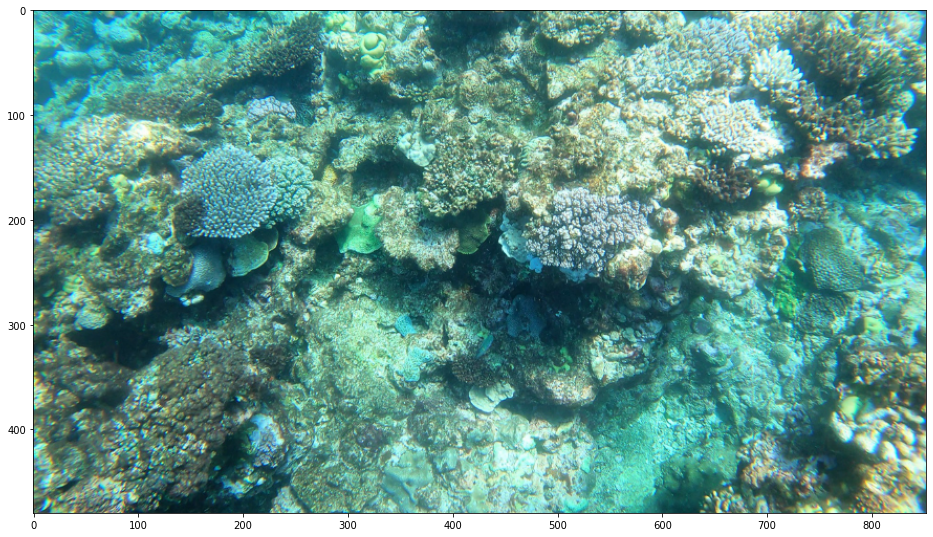

In [8]:
image, targets = ds_train[2200]
# image = image.permute(2,1,0).numpy()
# plt.imshow(image)
img = image.permute(1,2,0).cpu().numpy()
# plt.imshow(image.numpy().reshape((720, 1280,3)))
print(img.shape)
plt.figure(figsize=(16,18))


plt.imshow(img)

"""
boxes:  [[344. 105.  66.  73.]]
[66.]
"""

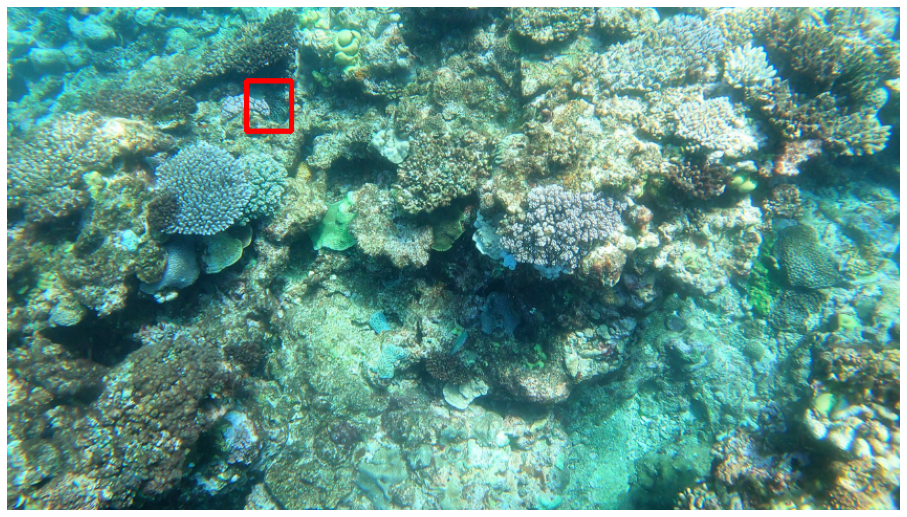

In [9]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)

img2 = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 18))

for box in boxes:
    cv2.rectangle(img2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
# fig.figure(figsize=(16,18))
ax.imshow(img2);

In [10]:
# del img1

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# model:

In [12]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(device)
    return model

model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# F2 cal:

In [13]:
from typing import List

import numpy as np
import torch
from torchvision.ops import box_iou


def calculate_score(
    preds: List[torch.Tensor],
    gts: List[torch.Tensor],
    iou_th: float
) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    if (5 * num_tp + 4 * num_fn + num_fp )!=0:
        score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp )
    else:
        score = np.nan
    if (num_tp+num_fn) != 0:
        recall = num_tp/ (num_tp+num_fn)
    else:
        recall=np.nan
    if (num_tp+num_fp)!=0:
        precission = num_tp/ (num_tp+num_fp)
    else:
        precission=np.nan


    return score, precission, recall




# Training:

In [14]:


# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
# confthre = 0.25
# n_batches, n_batches_val = len(dl_train), len(dl_val)
# validation_losses = []
# train_need = True

# for epoch in range(NUM_EPOCHS):
#     time_start = time.time()
#     loss_accum = 0
    
#     for batch_idx, (images, targets) in enumerate(dl_train, 1):
#         model = model.train()
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # Predict
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_accum += loss_value

#         # Back-prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()
        
#     # Validation 
#     val_loss_accum = 0
    
    
#     iou_ths = np.arange(0.3, 0.85, 0.05)
    
#     with torch.no_grad():
#         for batch_idx, (images, targets) in enumerate(dl_val, 1):
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             val_loss_dict = model(images, targets)
# #             print(val_loss_dict)
#             val_batch_loss = sum(loss for loss in val_loss_dict.values())
#             val_loss_accum += val_batch_loss.item()
            
            
#     val_f2_scores = []
    
#     for batch_idx, (images, targets) in enumerate(dl_val):


#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
#         model = model.eval()
#         preds = model(images)
            
#         for i in range(len(images)):
            
# #             print(preds[i]['boxes'].dtype)
# #             print(preds[i]['scores'].dtype)
# #             print(preds[i]['labels'].dtype)

#             preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
#             preds[i]['boxes']=preds[i]['boxes'].int()
#             score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
#             val_f2_scores.append(np.nanmean(score))
    
    
#     # Logging
#     val_loss = val_loss_accum / n_batches_val
#     train_loss = loss_accum / n_batches
#     validation_losses.append(val_loss)
    
#     # Save model
#     chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.pth'
#     torch.save(model.state_dict(), chk_name)
    
    
#     elapsed = time.time() - time_start
    
#     print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name} val F2: {np.nanmean(val_f2_scores):.3f} | time: [{elapsed:.0f} secs] ")   

# training 1:

In [15]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [16]:
loss_hist = Averager()
itr = 1
num_epochs = 12
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = None
confthre = 0.15
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


for epoch in range(num_epochs):
    loss_hist.reset()
    loss_accum = 0
    train_time_start = time.time()
    
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        model = model.train()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
#     for images, targets, image_ids in train_data_loader:
        
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_hist.send(loss_value)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    
    
    val_f2_scores = []
    iou_ths = np.arange(0.3, 0.85, 0.05)

    for batch_idx, (images, targets) in enumerate(dl_val):


        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
        model1 = model.eval()
        preds = model1(images)
            
        for i in range(len(images)):
            
            preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
            preds[i]['boxes']=preds[i]['boxes'].int()
            score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
            val_f2_scores.append(np.nanmean(score))
    
    
    PATH = f'fasterrcnn_resnet50_fpn-e{epoch}.pt'
    torch.save(model.state_dict(), PATH)
    
    elapsed = time.time() - train_time_start
    
    
    print("#"*20 + "   New epoch   " + "#"*20)    
    print(f"Epoch [{epoch}/{num_epochs}] train loss: {loss_hist.value}  |  saving file to: {PATH}  |  val F2: {np.nanmean(val_f2_scores):.3f} | time: [{elapsed:.0f} secs]")  

Iteration #50 loss: 0.10012897849082947
Iteration #100 loss: 0.42696648836135864
Iteration #150 loss: 0.20282533764839172
Iteration #200 loss: 0.10704188048839569
Iteration #250 loss: 0.08761967718601227
Iteration #300 loss: 0.16107894480228424
Iteration #350 loss: 0.14252378046512604
Iteration #400 loss: 0.3442462384700775
Iteration #450 loss: 0.08045836538076401
Iteration #500 loss: 0.5634786486625671
Iteration #550 loss: 0.30431458353996277
####################   New epoch   ####################
Epoch [0/12] train loss: 0  |  saving file to: fasterrcnn_resnet50_fpn-e0.pt  |  val F2: 0.196 | time: [739 secs]
Iteration #600 loss: 0.1503114551305771
Iteration #650 loss: 0.3344687223434448
Iteration #700 loss: 0.1513700932264328
Iteration #750 loss: 0.107431560754776
Iteration #800 loss: 0.16661955416202545
Iteration #850 loss: 0.3752862811088562
Iteration #900 loss: 0.19400815665721893
Iteration #950 loss: 0.2896701693534851
Iteration #1000 loss: 0.19807682931423187
Iteration #1050 los

In [17]:
# print("#"*12 + "hi absdfobasodb")

In [18]:
loaded_model = get_model()
loaded_model.load_state_dict(torch.load( "./fasterrcnn_resnet50_fpn-e0.pt"))

<All keys matched successfully>

In [19]:
idx = 6

images, targets= next(iter(dl_val))
images = list(img.to(device) for img in images)
# print(images[0])
print(len(images))
targets = [{k: v.to(torch.float32).to(device) if "box" in k else v.to(device) for k, v in t.items()} for t in targets]
        
boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
sample = images[idx].to(device)
# sample = images[idx].permute(1,2,0).cpu().numpy()
# sample
# # boxes
loaded_model.eval()

outputs1 = loaded_model([sample])
# outputs = [{k: v.detach().cpu().numpy() if "box" in k else v.to(device) for k, v in t.items()} for t in outputs]

8


In [20]:
outputs1

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)}]

In [21]:
boxes

array([[202, 116, 224, 136],
       [175, 127, 194, 141]], dtype=int32)

In [22]:
# images, boxes = torch.rand(2, 3, 400, 400).to(device), torch.rand(2, 11, 4).to(device)
# boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
# labels = torch.randint(0, 2, (4, 11)).to(device)
# images = list(image for image in images)
# targets = []
# for i in range(len(images)):
#     d = {}
#     d['boxes'] = boxes[i]
#     d['labels'] = labels[i]
#     targets.append(d)

In [23]:
# #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
# model = model.to(DEVICE)
# model.eval()
# output = model(images)
# output